In [ ]:
# ✅ to remove, just for testing models
import math
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings('ignore')

In [ ]:
df_preprocessed = pd.read_csv(r"data_preprocessed\with_outliers")

# Models

##  Random forest

In [ ]:
y = df_preprocessed.pop('average_rating')

X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, y, test_size=0.3, random_state=42)

In [ ]:
global_result = pd.DataFrame(columns=['model name','RMSE','mae','r2_score'])

In [ ]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [7, 10, 12, 15],
    'min_samples_split': [2,5],
    'min_samples_leaf': [5, 10, 15]
}
regr = RandomForestRegressor(random_state=0)

In [ ]:
clf = GridSearchCV(estimator = regr, param_grid = parameters,cv=3,verbose=2, n_jobs = -1)

In [ ]:
clf.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [ ]:
clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
best_rf = clf.best_estimator_
y_pred = clf.predict(X_test)

In [ ]:
importance_feature = pd.DataFrame(best_rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
importance_feature.sort_values(by=['Importance'],ascending=True,inplace=True)
importance_feature

,Importance
lang_ger,0.000022
lang_spa,0.000125
lang_en-GB,0.000192
lang_fre,0.001487
lang_en-US,0.002728
times_d1,0.004717
lang_eng,0.004809
times_d2,0.005984
lang_others,0.006314
editions_by_work,0.010643


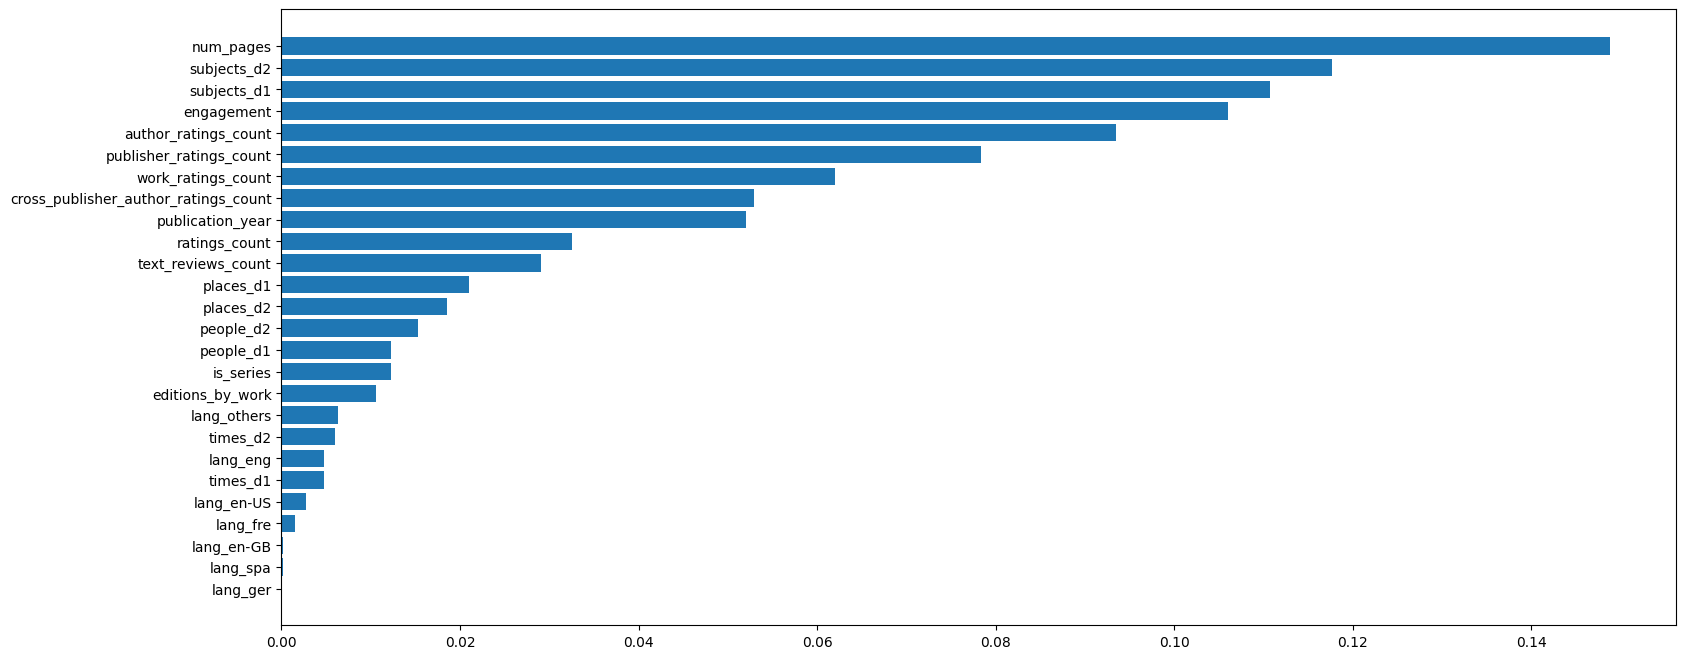

In [ ]:
plt.figure(figsize=(18,8))
plt.barh(y=importance_feature.index,width=importance_feature.values.reshape((-1,)))
plt.show()

In [ ]:
### Metrics
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Random Forest','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())


RMSE : 0.25939264882569735
mae : 0.18935588668323555
r2_score : 0.21


In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
pred.head(5)

,Actual,Predicted
0,3.92,3.989234
1,3.58,3.694723
2,4.13,3.974168
3,3.73,3.838373
4,4.05,3.765850


## XGBoost

In [ ]:
xgb = XGBRegressor()

In [ ]:
parameters = {'nthread':[6],
              'objective':['reg:linear'],
              'learning_rate': [0.01,.03], #so called `eta` value
              'max_depth': [5,7,15],
              'subsample': [0.5],
              'n_estimators': [500,1000]}

In [ ]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[00:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.03], 'max_depth': [5, 7, 15],
                         'n_estimators': [500, 1000], 'nthread': [6],
                         'objective': ['reg:linear'], 'subsample': [0.5]},
             verbose=True)

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.17544607457941103
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'nthread': 6, 'objective': 'reg:linear', 'subsample': 0.5}


In [ ]:
optimal_xgb = xgb_grid.best_estimator_

In [ ]:
y_pred = optimal_xgb.predict(X_test)

In [ ]:
### Metrics
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'XGBoost','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)

RMSE : 0.258106578611859
mae : 0.18755382690789565
r2_score : 0.22
